# Понижение размерности

В настоящей тетради мы рассмотрим различные методы понижения размертности данных, а именно: анализ главных компонент (PCA — Principal Component Analysis) и неотрицательная матричная факторизация (NMF — Non-negative Matrix Factorization). А также рассмотрим упрощённые примеры применения этих алгоритмов в задачах машинного обучения.

***

## Знакомство с алгоритмами

Ознакомимся с основными концепциями и положениями алгоритмов PCA, ICA и NMF в общих чертах.

### PCA

Анализ главных компонент суть алгоритм понижения размерности пространства данных, предназначенный для обобщения информации путём исключения наиболее коррелирующих (линейно зависимых) признаков, сохраняя при этом самую суть (наиболее линейно независимые признаки). PCA широко применим в машинном обучении и позволяет получить более показательное представление о данных, изначально требовавших большого количества измерений для собственного отображения. Основным математическим методом, лежащим в основе обозреваемого алгоритма, является вычилсение собственных значений и векторов матрицы корреляции.

### NMF

Неотрицательная матричная факторизация — альтернатива PCA, которая может и заменить его в случае, если в данных нет отрицательных значений. В отличие от PCA, представление вектора получается аддитивным способом, путем наложения компонентов без вычитания. Такие аддитивные модели эффективны для представления изображений и текста.

Подробнее о других алгоритмах понижения размерности можно прочитать [тут](https://scikit-learn.org/stable/modules/decomposition.html).
***

## Практические примеры

Посмотрим, как можно на практике применить PCA в гипотетической задаче машинного обучения при помощи фреймворка Scikit-Learn.

Начнём с импортирования библиотек.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from pandas import read_csv
from scipy.linalg import eigh
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Загрузим теперь наши данные и получим некоторые описательные статистики по каждому столбцу.

In [2]:
wine = read_csv("../datasets/winequality_red.csv")

wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Как видим, столбцов всего 12:

In [3]:
len(wine.columns)

12

Это значит, что для представления одной точки данных нужно 12 измерений. Посмотрим, получится ли понизить их количество при помощи PCA до трёх.

Однако сначала выполним рутинную преварительную обработку.

In [4]:
x_train_wine, x_test_wine, y_train_wine, y_test_wine = train_test_split(
    wine.iloc[:, :-1],
    wine.iloc[:, -1],
    test_size=0.25,
    random_state=52,
)

scaler = MinMaxScaler()
scaler.fit(x_train_wine)
x_train_scaled = scaler.transform(x_train_wine)
x_test_scaled = scaler.transform(x_test_wine)

### Применение PCA

Теперь, когда у нас имеются уже обработанные данные, применим метод главных компенент.

In [5]:
pca = PCA(n_components=3)

pca.fit(x_train_scaled)
x_train_pca = pca.transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

Визуализируем результат применения алгоритма для тренировочной выборки. Код для визуализации обернём в функцию, так как он нам ещё не раз пригодится.

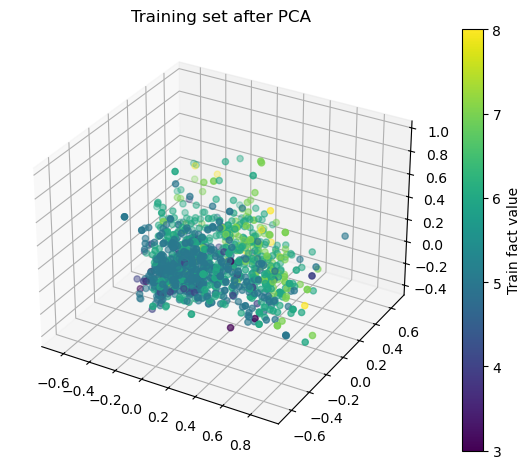

In [6]:
def scatter_3d(
    x_arr: ndarray,
    y_arr: ndarray,
    z_arr: ndarray,
    *,
    color: ndarray,
    axis_title: str,
    colorbar_label: str,
) -> None:
    fig = plt.figure()
    axis = fig.add_subplot(projection="3d")
    scatter = axis.scatter(x_arr, y_arr, z_arr, c=color)
    colorbar = fig.colorbar(scatter)

    axis.set_title(axis_title)
    colorbar.set_label(colorbar_label)
    plt.tight_layout()
    plt.show()


scatter_3d(
    x_train_pca[:, 0],
    x_train_pca[:, 1],
    x_train_pca[:, 2],
    color=y_train_wine,
    axis_title="Training set after PCA",
    colorbar_label="Train fact value",
)

И для тестовой выборки сделаем то же.

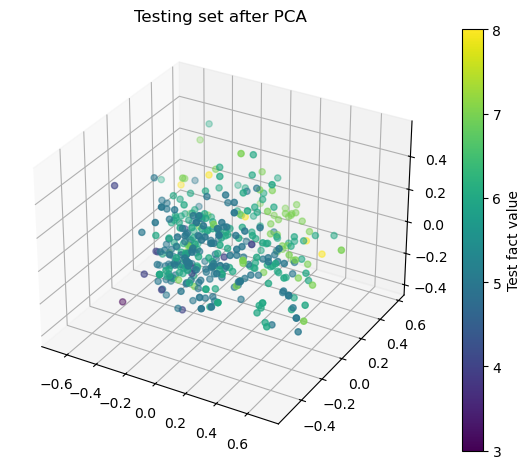

In [7]:
scatter_3d(
    x_test_pca[:, 0],
    x_test_pca[:, 1],
    x_test_pca[:, 2],
    color=y_test_wine,
    axis_title="Testing set after PCA",
    colorbar_label="Test fact value",
)

Рассмотрим теперь другой метод понижения размерности.

### Применение NMF

Применим сейчас метод неотрицательной матричной факторизации.

In [8]:
nmf = NMF(n_components=3)

nmf.fit(x_train_scaled)
x_train_nmf = nmf.transform(x_train_scaled)
x_test_nmf = nmf.transform(x_test_scaled)

Так же визуализируем результат применения алгоритма для тренировочной выборки.

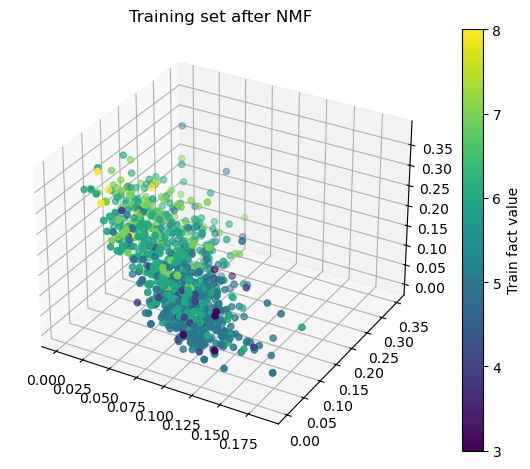

In [9]:
scatter_3d(
    x_train_nmf[:, 0],
    x_train_nmf[:, 1],
    x_train_nmf[:, 2],
    color=y_train_wine,
    axis_title="Training set after NMF",
    colorbar_label="Train fact value",
)

И для тестовой выборки.

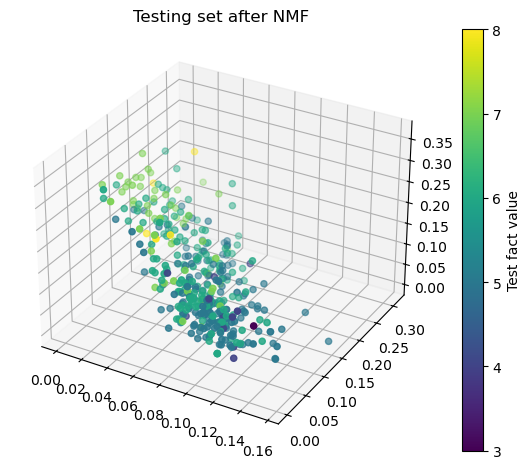

In [10]:
scatter_3d(
    x_test_nmf[:, 0],
    x_test_nmf[:, 1],
    x_test_nmf[:, 2],
    color=y_test_wine,
    axis_title="Testing set after NMF",
    colorbar_label="Test fact value",
)

Попробуем теперь обучить модель, пользуясь разобраными выше методами.

### Обучение моделей и оценки

В этом подразделе обучим обыкновенный `sklearn.linear_model.LinearRegression` с параметрами по умолчанию и оценим качество предсказаний с различными количествами компонент для алгоритмов понижения размерности.

Код для применения алгоритма, тренировки и оценки модели обернём функцию, чтоб использовать снова.

In [11]:
def train_evaluate_regressor(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    *,
    algorithm,
    n_components: int,
) -> float:
    algorithm_initialized = algorithm(n_components=n_components)
    regressor = LogisticRegression()

    algorithm_initialized.fit(x_train)
    x_train_processed = algorithm_initialized.transform(x_train)
    x_test_processed = algorithm_initialized.transform(x_test)
    regressor.fit(x_train_processed, y_train)
    y_predicted = regressor.predict(x_test_processed)
    error = float(mean_absolute_percentage_error(y_predicted, y_test))

    return error

#### PCA

Для начала попробуем с PCA и количеством компонентов равным восьми.

In [12]:
train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=PCA,
    n_components=8,
)

0.08323809523809522

Понизим количество компонент до четырёх.

In [13]:
train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=PCA,
    n_components=4,
)

0.09092857142857143

И до трёх.

In [14]:
train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=PCA,
    n_components=3,
)

0.09126190476190477

#### NMF

А сейчас приступим к NMF. Настройки алгоритмов на каждом шаге изменим. Начнём теперь с четырёх и закончим теперь вообще двумя.

Четыре компонента:

In [15]:
train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=NMF,
    n_components=4,
)

0.09974999999999999

Три компонента:

In [16]:
train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=NMF,
    n_components=3,
)

0.09541666666666668

И, наконец, оставим всего два компонента.

In [17]:
train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=NMF,
    n_components=2,
)

0.11908333333333335

Приступим сейчас к разделу, который обеспечит лучшее понимание PCA.

***

## Реализация PCA

Для того чтобы лучше понять, как именно работает алгоритм PCA, напишем собственную его реализацию по образу применения идентичную классу из Scikit-Learn.

Опишем функционал методов `fit()` и `transform()`.
1. Метод `fit()`:
    * Вычисление среднего значения: Среднее значение каждого признака во входных данных X вычисляется с помощью np.mean().
    * Центрирование данных: Входные данные центрируются путем вычитания среднего значения из каждого признака.
    * Ковариационная матрица: Ковариационная матрица вычисляется с использованием np.cov().
    * Разложение по собственным значениям: Собственные значения и собственные векторы ковариационной матрицы вычисляются с использованием scipy.linalg.eigh(). Параметр eigvals используется для выбора подмножества собственных значений и собственных векторов на основе количества сохраняемых компонентов.
    * Сортировка компонентов: Собственные векторы сортируются на основе соответствующих собственных значений в порядке убывания.
2. Метод `transform()`:
    * Центрирование данных: Входные данные центрируются с использованием ранее вычисленного среднего значения.
    * Проекция: Центрированные данные проецируются на выбранные основные компоненты с использованием матричного умножения.


Приступим к написанию кода.

In [22]:
class PrincipalComponentAnalysis:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, x):
        # Calculate mean of each feature
        self.mean = np.mean(x, axis=0)

        # Center the data by subtracting the mean
        centered_data = x - self.mean

        # Compute the covariance matrix
        covariance_matrix = np.cov(centered_data, rowvar=False)

        # Compute the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = eigh(
            covariance_matrix,
            eigvals=(
                len(covariance_matrix) - self.n_components, len(covariance_matrix) - 1
            ),
        )

        # Sort the eigenvectors based on eigenvalues
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.components = eigenvectors[:, sorted_indices]

    def transform(self, x):
        # Center the data
        centered_data = x - self.mean

        # Project the data on the principal components
        projected_data = np.dot(centered_data, self.components)
        return projected_data

    def fit_transorm(self, x):
        self.fit(x)
        transformed = self.transform(x)
        return transform

Проверим, какую точность может обеспечить этот класс, если установить те же количества компонентов, что и для оригинального `PCA`.

In [23]:
eight_components = train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=PrincipalComponentAnalysis,
    n_components=8,
)
four_components = train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=PrincipalComponentAnalysis,
    n_components=4,
)
three_components = train_evaluate_regressor(
    x_train_scaled,
    x_test_scaled,
    y_train_wine,
    y_test_wine,
    algorithm=PrincipalComponentAnalysis,
    n_components=3,
)

print(
    f"Regressor accuracy with 8 components for PCA: {eight_components}\n"
    f"Regressor accuracy with 4 components for PCA: {four_components}\n"
    f"Regressor accuracy with 3 components for PCA: {three_components}"
)

Regressor accuracy with 8 components for PCA: 0.08323809523809522
Regressor accuracy with 4 components for PCA: 0.09092857142857143
Regressor accuracy with 3 components for PCA: 0.09126190476190477


Наша реализация практически никак не отличается от готового решения от Scikit-Learn!

***

## Заключение

В этой тетради мы рассмотрели элементарные примеры использования алгоритмов понижения размерности и изучили, как можно при их помощи визуализировать данные. Также мы применили алгоритмы в процессе решения гипотетической задачи машинного обучения (оценка качества красного вина). Ещё мы реализовали собственный класс для применения алгоритма анализа главных компонент!

Выполнив несложные эксперименты с количеством компонент, можно сказать, NMF с набором данных о качестве красного вина справился хуже, чем PCA. Интересно заметить, что неотрицательная матричная факторизация показала себя лучше именно при `n_components=3`.

Алгоритмы понижения размерности являются очень полезными инструментами при визауализации многомерных данных и потенциально могут ускорить процесс обучения вашей модели.